# Подготовка модели распознавания рукописных букв и цифр

Вам предстоит самостоятельно обучить модель для задачи распознавания рукописных букв и цифр с помощью датасета `emnist`. Результатом должна быть обученная модель, сохранённая в файл `model.pkl`.

Можете воспользоваться предложенным порядком действий и подсказками из этого ноутбука или подойти к решению задачи самостоятельно и написать всё с нуля. То же касается и процесса упаковки модели в сервис для распознавания самостоятельно написанных символов.

В этом ноутбуке комментариями и символами `...` отмечены места для вашего кода.

Перед отправкой решения убедитесь, что все ячейки ноутбука выполняются последовательно без ошибок, если запустить `Kernel -> Restart & Run All`.

Успехов!

### 1. Установите и импортируйте необходимые библиотеки

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import emnist
from emnist import extract_training_samples, extract_test_samples
import seaborn as sns
#from sklearn.metrics import accuracy_score, confusion_matrix
#import seaborn as sns
#from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical # преобразование target
from tensorflow.keras.models import load_model

2024-12-14 18:29:12.976133: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 18:29:12.984549: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 18:29:13.016947: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734193753.075395   32964 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734193753.092760   32964 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-14 18:29:13.148752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### 2. Загрузите датасет и проанализируйте его

Датасет в качестве лейблов (или таргетов) содержит числа от 0 до 46. Каждому числу соответствует ASCII-код некоторого символа. Пары «лейбл — код» хранятся в файле `emnist-balanced-mapping.txt`.
Выведите на экран количество семплов в каждом сплите датасета и размер изображений. Также для каждого лейбла выведите соответствующий ему символ и количество тренировочных семплов, приходящееся на него.
Посмотрите на несколько примеров изображений.

_Подсказка: чтобы получить символ из ASCII-кода, нужно воспользоваться функцией_ `chr()`. _Для вашего удобства можно построить словарь_ (`dict`) _соответствий._

In [ ]:
# !!!проблема загрузки! перезалить файл в .cache/emnist !!!
images_train, labels_train = emnist.extract_training_samples('balanced')
images_test, labels_test = emnist.extract_test_samples('balanced')

print(f'Train: {...} samples')
print(f'Test: {...} samples')
print(f'Image size: {...}')

Train: Ellipsis samples
Test: Ellipsis samples
Image size: Ellipsis


In [4]:
labels_train

array([45, 36, 43, ..., 23, 31,  8], dtype=uint8)

In [5]:
# Получаем размеры данных
num_train_samples = images_train.shape[0]
num_test_samples = images_test.shape[0]
image_shape = images_train.shape[1:]
# Выводим количество семплов и размер изображений
print(f'Количество тренировочных семплов: {num_train_samples}')
print(f'Количество тестовых семплов: {num_test_samples}')
print(f'Размер изображений: {image_shape}')

Количество тренировочных семплов: 112800
Количество тестовых семплов: 18800
Размер изображений: (28, 28)


In [6]:
num_train_samples = images_train.shape[0]
num_test_samples = images_test.shape[0]
image_shape = images_train.shape[1:]
    

In [7]:
# Загружаем соответствие лейблов и символов
with open('emnist-balanced-mapping.txt', 'r') as f:
    label_mapping = f.readlines()

In [8]:
label_mapping

['0 48\n',
 '1 49\n',
 '2 50\n',
 '3 51\n',
 '4 52\n',
 '5 53\n',
 '6 54\n',
 '7 55\n',
 '8 56\n',
 '9 57\n',
 '10 65\n',
 '11 66\n',
 '12 67\n',
 '13 68\n',
 '14 69\n',
 '15 70\n',
 '16 71\n',
 '17 72\n',
 '18 73\n',
 '19 74\n',
 '20 75\n',
 '21 76\n',
 '22 77\n',
 '23 78\n',
 '24 79\n',
 '25 80\n',
 '26 81\n',
 '27 82\n',
 '28 83\n',
 '29 84\n',
 '30 85\n',
 '31 86\n',
 '32 87\n',
 '33 88\n',
 '34 89\n',
 '35 90\n',
 '36 97\n',
 '37 98\n',
 '38 100\n',
 '39 101\n',
 '40 102\n',
 '41 103\n',
 '42 104\n',
 '43 110\n',
 '44 113\n',
 '45 114\n',
 '46 116\n']

In [9]:
# Создаем словарь соответствий
label_dict = {}
for entry in label_mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

In [10]:
# Подсчитываем количество тренировочных семплов для каждого лейбла
label_counts = np.bincount(labels_train)

In [11]:
# Выводим символы и количество семплов
print("Количество тренировочных семплов для каждого символа:")
for label, count in enumerate(label_counts):
    if count > 0:  # Печатаем только те лейблы, которые встречаются в выборке
        symbol = label_dict.get(label, '?')  # Получаем символ
        print(f'Символ: {symbol}, Лейбл: {label}, Количество: {count}')

Количество тренировочных семплов для каждого символа:
Символ: 0, Лейбл: 0, Количество: 2400
Символ: 1, Лейбл: 1, Количество: 2400
Символ: 2, Лейбл: 2, Количество: 2400
Символ: 3, Лейбл: 3, Количество: 2400
Символ: 4, Лейбл: 4, Количество: 2400
Символ: 5, Лейбл: 5, Количество: 2400
Символ: 6, Лейбл: 6, Количество: 2400
Символ: 7, Лейбл: 7, Количество: 2400
Символ: 8, Лейбл: 8, Количество: 2400
Символ: 9, Лейбл: 9, Количество: 2400
Символ: A, Лейбл: 10, Количество: 2400
Символ: B, Лейбл: 11, Количество: 2400
Символ: C, Лейбл: 12, Количество: 2400
Символ: D, Лейбл: 13, Количество: 2400
Символ: E, Лейбл: 14, Количество: 2400
Символ: F, Лейбл: 15, Количество: 2400
Символ: G, Лейбл: 16, Количество: 2400
Символ: H, Лейбл: 17, Количество: 2400
Символ: I, Лейбл: 18, Количество: 2400
Символ: J, Лейбл: 19, Количество: 2400
Символ: K, Лейбл: 20, Количество: 2400
Символ: L, Лейбл: 21, Количество: 2400
Символ: M, Лейбл: 22, Количество: 2400
Символ: N, Лейбл: 23, Количество: 2400
Символ: O, Лейбл: 24

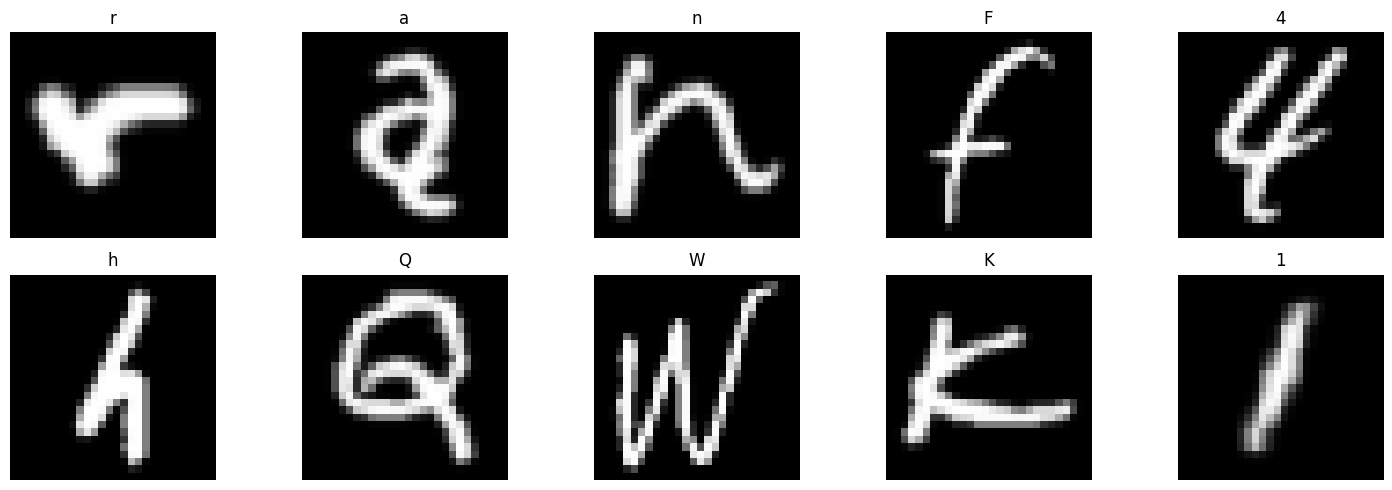

In [12]:
# Функция для отображения нескольких примеров изображений
def display_examples(images, labels, num_examples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_examples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(label_dict.get(labels[i], '?'))  # Отображаем символ
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Отображаем 10 примеров изображений из тренировочной выборки
display_examples(images_train, labels_train, num_examples=10)

In [13]:
label_dict

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

### 3. Подготовьте датасет для обучения и валидации

_Подсказка: чтобы вытянуть изображения в вектор, понадобится метод_ `reshape` _из библиотеки_ `numpy`.

In [14]:
# Векторизация данных с помощью numpy.reshape
X_train = np.reshape(images_train, (num_train_samples, -1))  # Превращаем каждое изображение в одномерный массив
y_train = labels_train  # Метки остаются в одномерном массиве
X_test = np.reshape(images_test, (num_test_samples, -1))  # Превращаем тестовые изображения в одномерные массивы
y_test = labels_test  # Тестовые метки остаются в одномерном массиве

print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (112800, 784)
Test: (18800, 784)


In [15]:
# Проверка форм
print(f'Форма X_train: {X_train.shape}')  # Должно быть (num_train_samples, 784)
print(f'Форма y_train: {y_train.shape}')  # Должно быть (num_train_samples,)
print(f'Форма X_test: {X_test.shape}')    # Должно быть (num_test_samples, 784)
print(f'Форма y_test: {y_test.shape}')    # Должно быть (num_test_samples,)

Форма X_train: (112800, 784)
Форма y_train: (112800,)
Форма X_test: (18800, 784)
Форма y_test: (18800,)


In [16]:
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### 4. Выберите модель, обучите её, протестируйте и сохраните

Выведите на экран точность вашей модели. Выведите и проанализируйте матрицу ошибок. Какие два символа она чаще всего путает? На каком символе модель чаще всего ошибается?

#### Keras

In [17]:
# Изменение формы изображений для работы с Keras
# Изображения имеют размерность (num_samples, height, width). 
# Было 28x28, теперь добавляем размерность канала (1 - для черно-белого изображения)
K_train = images_train.reshape(num_train_samples, 28, 28, 1)
K_test = images_test.reshape(num_test_samples, 28, 28, 1)

In [18]:
# Нормализация данных
K_train = K_train.astype('float32') / 255.0
K_test = K_test.astype('float32') / 255.0

In [19]:
# Преобразование меток в категориальный формат
labels_train_categorical = to_categorical(labels_train, num_classes=len(label_dict))
labels_test_categorical = to_categorical(labels_test, num_classes=len(label_dict))

In [20]:
# Создание модели CNN
model_k = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(47, activation='softmax')  # 47 - количество классов в EMNIST Balanced
])

/home/leostuchchi/anaconda3/envs/CV/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-14 18:29:24.084355: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
# Компиляция модели
model_k.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
# Обучение модели
model_k.fit(K_train, labels_train_categorical, epochs=9, batch_size=32, validation_split=0.1)

Epoch 1/9


2024-12-14 18:29:25.351021: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 318366720 exceeds 10% of free system memory.


3173/3173 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6883 - loss: 1.0749

2024-12-14 18:32:33.130538: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35374080 exceeds 10% of free system memory.


3173/3173 ━━━━━━━━━━━━━━━━━━━━ 195s 61ms/step - accuracy: 0.6883 - loss: 1.0748 - val_accuracy: 0.8389 - val_loss: 0.4658
Epoch 2/9
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 205s 62ms/step - accuracy: 0.8617 - loss: 0.4005 - val_accuracy: 0.8628 - val_loss: 0.3878
Epoch 3/9
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 172s 54ms/step - accuracy: 0.8797 - loss: 0.3312 - val_accuracy: 0.8715 - val_loss: 0.3651
Epoch 4/9
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 229s 63ms/step - accuracy: 0.8917 - loss: 0.2917 - val_accuracy: 0.8698 - val_loss: 0.3584
Epoch 5/9
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 216s 68ms/step - accuracy: 0.9015 - loss: 0.2581 - val_accuracy: 0.8677 - val_loss: 0.3770
Epoch 6/9
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 180s 57ms/step - accuracy: 0.9090 - loss: 0.2307 - val_accuracy: 0.8704 - val_loss: 0.3646
Epoch 7/9
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 206s 65ms/step - accuracy: 0.9176 - loss: 0.2065 - val_accuracy: 0.8640 - val_loss: 0.4108
Epoch 8/9
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 214s 67ms/step - accuracy: 0.9237 - loss: 0.1

In [23]:
# Оценка модели
test_loss, test_accuracy = model_k.evaluate(K_test, labels_test_categorical)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

  4/588 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8464 - loss: 0.4544

2024-12-14 19:00:46.162180: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58956800 exceeds 10% of free system memory.


588/588 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.8698 - loss: 0.4399
Test loss: 0.43613743782043457, Test accuracy: 0.8714361786842346


In [24]:
# Получение прогнозов модели
y_pred = model_k.predict(K_test)
# Получение классов с максимальными вероятностями
y_pred_classes = np.argmax(y_pred, axis=1)  

2024-12-14 19:00:59.106299: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58956800 exceeds 10% of free system memory.


588/588 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step


In [25]:
y_pred_classes

array([41, 39,  9, ..., 21, 26, 33])

In [26]:
# Перевод предсказанных классов в символы
predicted_symbols = [label_dict[label] for label in y_pred_classes]

In [27]:
label_dict[label] 

't'

In [28]:
# Вычисление точности
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(labels_test, y_pred_classes)
acc = accuracy.result().numpy()  # Получение результата в виде числа

In [29]:
# Построение матрицы ошибки
cm = tf.math.confusion_matrix(labels_test, y_pred_classes)

In [30]:
for i in cm:
    print(i)

tf.Tensor(
[314   0   0   0   0   0   0   0   0   0   0   0   1   8   0   0   0   0
   0   0   0   0   1   0  70   0   1   0   0   0   3   0   0   0   0   0
   0   0   1   0   0   0   0   0   1   0   0], shape=(47,), dtype=int32)
tf.Tensor(
[  0 282   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  33   0   0  83   0   1   0   0   0   0   0   0   0   0   0   0   0   1
   0   0   0   0   0   0   0   0   0   0   0], shape=(47,), dtype=int32)
tf.Tensor(
[  0   0 335   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   2   0   1   0   0   0   0   0   0   0   0   0   0   0   1   0  47
   8   0   1   0   0   1   0   0   2   0   0], shape=(47,), dtype=int32)
tf.Tensor(
[  1   0   0 392   0   0   0   0   0   2   0   1   0   0   0   0   0   0
   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
   0   0   0   1   0   1   0   0   0   0   0], shape=(47,), dtype=int32)
tf.Tensor(
[  0   0   0   0 366   0   0   1   0   2   1   0   0   0   0   0   0 

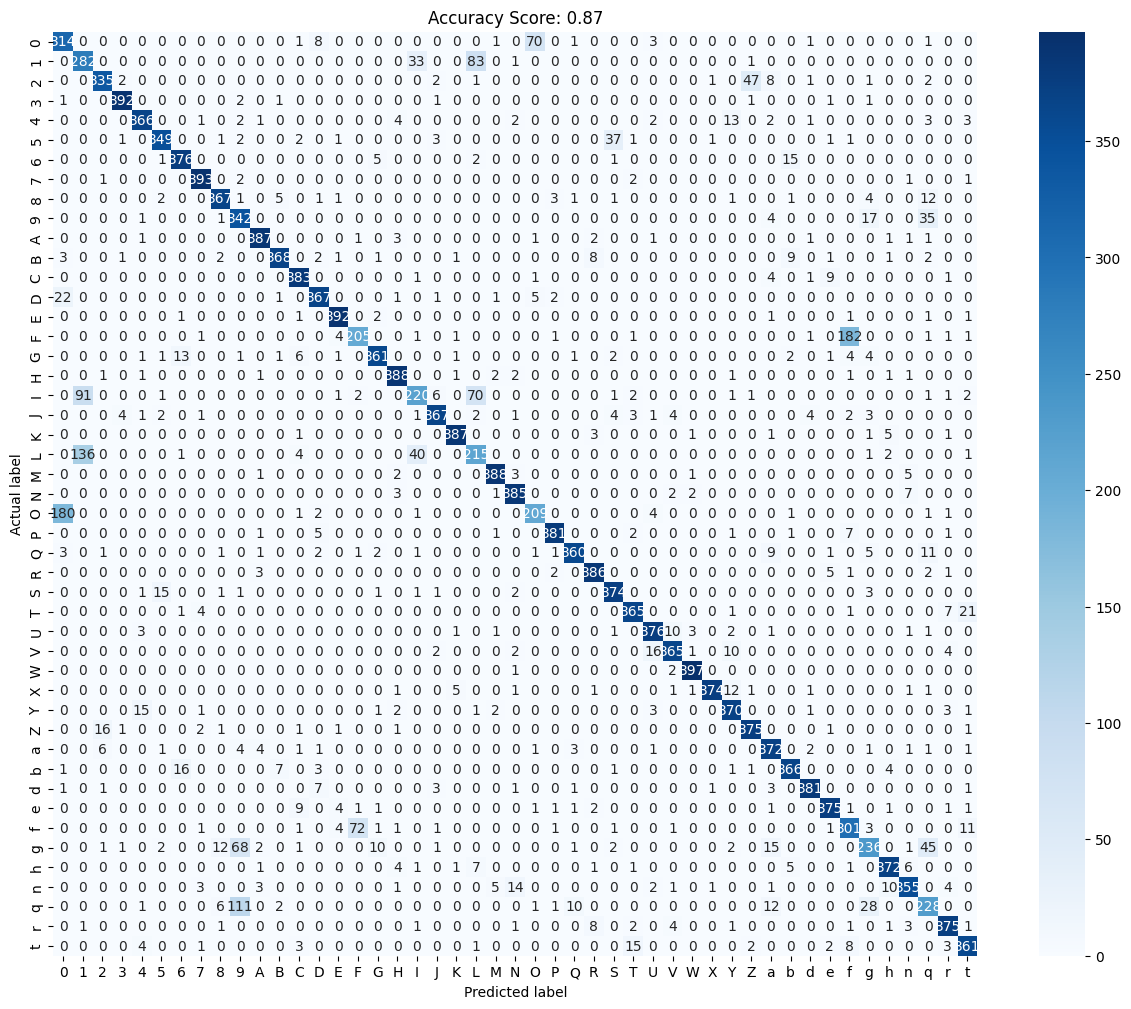

In [31]:
# Визуализация матрицы ошибок
plt.figure(figsize=(16, 12))
sns.heatmap(cm.numpy(), annot=True, square=True, cmap='Blues', fmt='g',
             xticklabels=[label_dict[i] for i in range(len(label_dict))],
             yticklabels=[label_dict[i] for i in range(len(label_dict))])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {acc:.2f}')

plt.show()

In [32]:
with open(os.path.join('myapp', 'model.pkl'),'wb') as f:
    pickle.dump(model_k, f)

In [33]:
# Сохранение модели в формате keras
model_k.save(os.path.join('myapp', 'model.keras'))

Проверка предсказаний

In [34]:
def predict(x, model_k, label_dict):
    # Подготовка данных
    x = x.reshape(1, 28, 28, 1)  # Добавляем размерность канала
    x = x.astype('float32') / 255.0  # Нормализация данных
    
    # Получаем предсказания модели
    predictions = model_k.predict(x)
    
    # Получаем индекс максимального значения (предсказанный класс)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Получение символа из словаря label_dict
    pred = label_dict[predicted_class]
    
    return pred


def predict_examples(images, model_k, label_dict):
    for i in images:
        pred = predict(i, model_k, label_dict)  
        print(pred)


# предсказания на тесте
images_to_predict = images_test[1:5]  # Измените на нужные вам изображения
predict_examples(images_to_predict, model_k, label_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
e
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Q
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
9


Выведите на экран точность вашей модели. 
Выведите и проанализируйте матрицу ошибок. 
Какие два символа она чаще всего путает? 
На каком символе модель чаще всего ошибается?

In [35]:
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Test loss: 0.43613743782043457, Test accuracy: 0.8714361786842346


чаще всего путает 'f' вместо 'F' - 182 случая


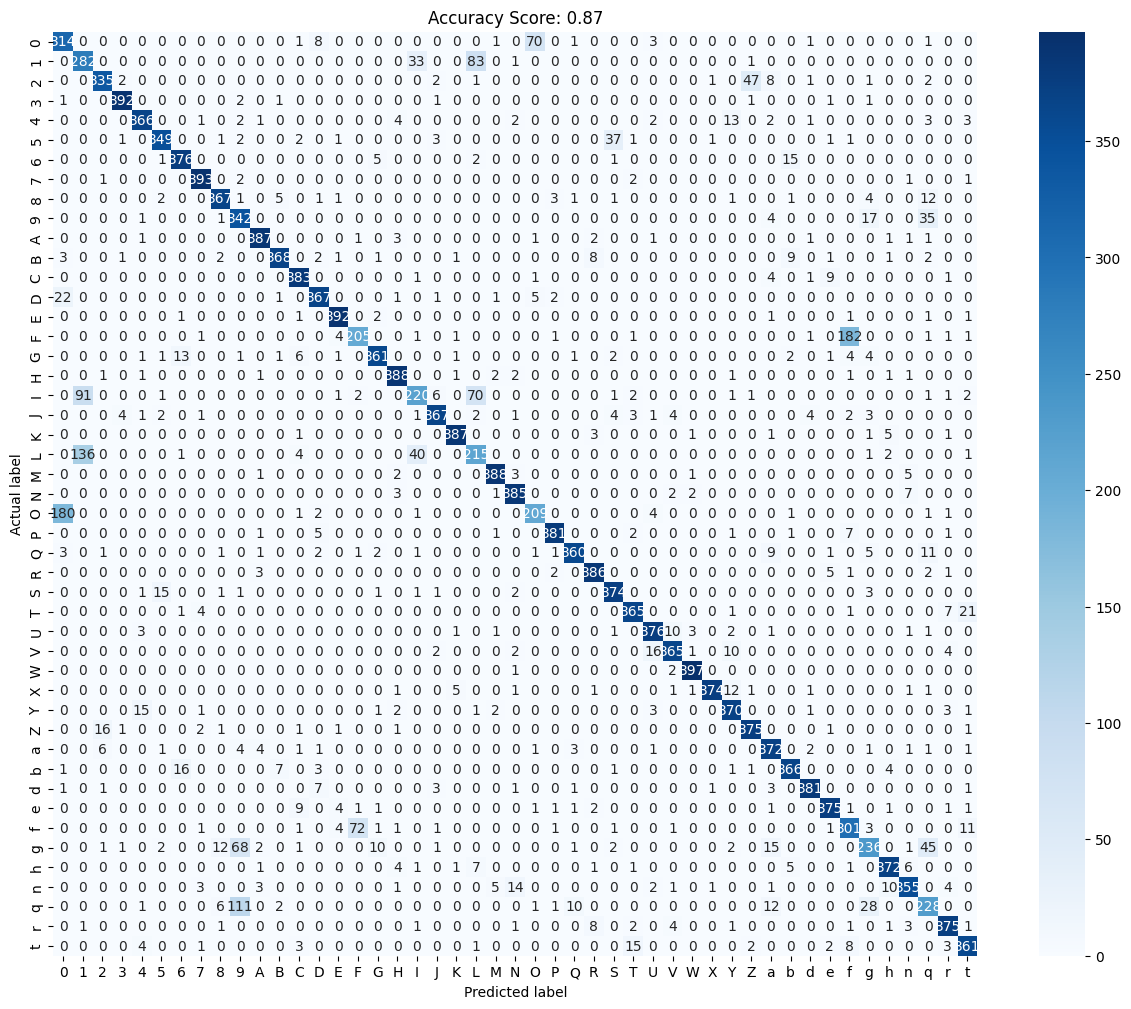

In [36]:
# Визуализация матрицы ошибок
plt.figure(figsize=(16, 12))
sns.heatmap(cm.numpy(), annot=True, square=True, cmap='Blues', fmt='g',
             xticklabels=[label_dict[i] for i in range(len(label_dict))],
             yticklabels=[label_dict[i] for i in range(len(label_dict))])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {acc:.2f}')

plt.show()